In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from qiskit_optimization import QuadraticProgram

# Creating synthetic data for P2P energy training

In [7]:
samples = np.random.normal(loc=11.5, scale=4.7, size=15000)

hours = np.arange(24)
min_value = 10
max_value = 123

participants_dict_per_hourdict={}
for hour in hours:
    participants_dict_per_hourdict[f"{hour}"] = 0
    for sample in samples:
        if np.abs(sample - hour)<.5:
              participants_dict_per_hourdict[f"{hour}"]+=1 
participants_by_hour = np.asarray(list(participants_dict_per_hourdict.values()))
participants_by_hour = participants_by_hour/np.max(participants_by_hour) * max_value

#either we set the values below min_value to min_value or throw it a away
#participants_by_hour[participants_by_hour<min_value] = 0
#participants_by_hour = np.clip(participants_by_hour/np.max(participants_by_hour) * max_value, a_min=min_value, a_max=max_value)

columns = ['Hour', 'Participant', 'Type', 'Price (cents/KWh)', 'Quantity (KW)']
df = pd.DataFrame(columns=columns)

# Generate bids and asks for each hour
for hour in hours:
    #print(hour)
    participants_by_hour[hour]=int(participants_by_hour[hour])
    if participants_by_hour[hour]%2!=0:
        participants_by_hour[hour]-=1
    print(f"hour:{hour}",participants_by_hour[hour])
    num_prosumers = int(participants_by_hour[hour]/2)
    num_consumers = int(participants_by_hour[hour] - num_prosumers)


    if participants_by_hour[hour] > 0:
    # Generate prosumer bids
        prosumer_bids = pd.DataFrame({
            'Hour': hour,
            'Participant': np.arange(num_prosumers),
            'Type': 'Bid',
            'Price (cents/KWh)': np.random.randint(8, 33, size=num_prosumers),
            'Quantity (KW)': np.random.randint(1, 6, size=num_prosumers)
        })

    # Generate consumer asks
        consumer_asks = pd.DataFrame({
            'Hour': hour,
            'Participant': np.arange(num_prosumers, num_prosumers + num_consumers),
            'Type': 'Ask',
            'Price (cents/KWh)': np.random.randint(8, 33, size=num_consumers),
            'Quantity (KW)': np.random.randint(5, 11, size=num_consumers)
        })
    else:
        # Generate prosumer bids
        prosumer_bids = pd.DataFrame({
            'Hour': hour,
            'Participant': [None],
            'Type': 'Bid',
            'Price (cents/KWh)': 0,
            'Quantity (KW)': 0
        })

    # Generate consumer asks
        consumer_asks = pd.DataFrame({
            'Hour': hour,
            'Participant': [None],
            'Type': 'Ask',
            'Price (cents/KWh)': 0,
            'Quantity (KW)': 0
        })
    

    # Concatenate prosumer bids and consumer asks
    hour_data = pd.concat([prosumer_bids, consumer_asks], ignore_index=True)

    # Add the generated data to the main DataFrame
    df = pd.concat([df, hour_data], ignore_index=True)

    df["Participant"]
# Sort the DataFrame based on hour and participant
df.sort_values(by=['Hour', 'Participant'], inplace=True, ignore_index=True)

hour:0 6.0
hour:1 8.0
hour:2 14.0
hour:3 24.0
hour:4 34.0
hour:5 48.0
hour:6 64.0
hour:7 84.0
hour:8 92.0
hour:9 102.0
hour:10 116.0
hour:11 122.0
hour:12 120.0
hour:13 114.0
hour:14 112.0
hour:15 92.0
hour:16 76.0
hour:17 60.0
hour:18 48.0
hour:19 34.0
hour:20 22.0
hour:21 16.0
hour:22 10.0
hour:23 4.0


In [8]:
df[df["Hour"]==23]

,Hour,Participant,Type,Price (cents/KWh),Quantity (KW)
1418,23,0,Bid,13,4
1419,23,1,Bid,12,3
1420,23,2,Ask,31,7
1421,23,3,Ask,8,10


In [9]:
df_length_per_hour = df.groupby('Hour').size()

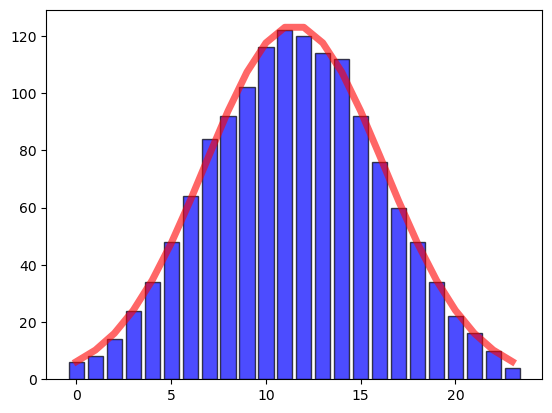

In [10]:
#comparing to exact distribution
#also cutting the cases when participants are below 10
x = np.linspace(0,23,24)

df_length_per_hour = df.groupby('Hour').size()
#df_length_per_hour[df_length_per_hour<10] = 0
plt.bar(df_length_per_hour.index, df_length_per_hour.values, color='blue', alpha=0.7,edgecolor='black')
plt.plot(hours,123* norm.pdf(x, loc = 11.5, scale = 4.7)/max(norm.pdf(x, loc = 11.5, scale = 4.7)),
       'r-', lw=5, alpha=0.6, label='norm pdf')

# Creating QUBO

The cost function in the original formulation

$\max\limits_{x_{ij}} \sum\limits_{i=1}^{C}\sum\limits_{j=1}^{P} x_{ij}(p_i-p_j){\text{min}}\{Q_i,Q_j\}$

Subject to

$\sum\limits_{i}^C x_{ij}{\text{min}}\{Q_i,Q_j\}\leq Q_j$


$\sum\limits_{j}^P x_{ij}{\text{min}}\{Q_i,Q_j\}\leq Q_i$

In [11]:
#creating the Quadratic program
mod = QuadraticProgram("ET")
print(mod.prettyprint())

Problem name: ET

Minimize
  0

Subject to
  No constraints

  No variables



As of yet we are going to fill this up with the bids and asks from a given time interval, e.g. 2.

In [12]:
df[df["Hour"]==0]

,Hour,Participant,Type,Price (cents/KWh),Quantity (KW)
0,0,0,Bid,31,3
1,0,1,Bid,27,4
2,0,2,Bid,10,5
3,0,3,Ask,27,6
4,0,4,Ask,28,9
5,0,5,Ask,25,6


In [13]:
hour = 23

for i in range(int(len(df[df["Hour"]==hour])/2)): #consumers
    for j in range(int(len(df[df["Hour"]==hour])/2),int(len(df[df["Hour"]==hour]))): #prosumers
        mod.binary_var(name=f"x_{int(i)}_{int(j)}")
print(mod.prettyprint())

Problem name: ET

Minimize
  0

Subject to
  No constraints

  Binary variables (4)
    x_0_2 x_0_3 x_1_2 x_1_3



Now we assign the cost function given above.

In [14]:
#creating the cost function
#cost
lind_dict={}

for i in range(int(len(df[df["Hour"]==hour])/2)): #consumers
    for j in range(int(len(df[df["Hour"]==hour])/2),int(len(df[df["Hour"]==hour]))):
        lind_dict[f"x_{int(i)}_{int(j)}"]=df.loc[df["Hour"] == hour, "Price (cents/KWh)"].values[i]-df.loc[df["Hour"] == hour, "Price (cents/KWh)"].values[j]\
            *min(df.loc[df["Hour"] == 2, "Quantity (KW)"].values[i],df.loc[df["Hour"] == 2, "Quantity (KW)"].values[j])


In [15]:
lind_dict

{'x_0_2': -18, 'x_0_3': 5, 'x_1_2': -112, 'x_1_3': 4}

In [16]:
mod.maximize(linear=lind_dict)
print(mod.prettyprint())

Problem name: ET

Maximize
  -18*x_0_2 + 5*x_0_3 - 112*x_1_2 + 4*x_1_3

Subject to
  No constraints

  Binary variables (4)
    x_0_2 x_0_3 x_1_2 x_1_3



We create the constraints given above.

In [17]:
#constraint consumers
constraints_consumer={}
for i in range(int(len(df[df["Hour"]==hour])/2)):
    constraints_consumer[f"consumer_ID_{i}"] = {}
    for j in range(int(len(df[df["Hour"]==hour])/2),int(len(df[df["Hour"]==hour]))):
        constraints_consumer[f"consumer_ID_{i}"][f"x_{i}_{j}"] = min(df.loc[df["Hour"] == hour, "Quantity (KW)"].values[i],df.loc[df["Hour"] == hour, "Quantity (KW)"].values[j])

#constraint prosumers
constraints_prosumer={}
for j in range(int(len(df[df["Hour"]==hour])/2),int(len(df[df["Hour"]==hour]))):
    constraints_prosumer[f"prosumer_ID_{j}"] = {}
    for i in range(int(len(df[df["Hour"]==hour])/2)):
        constraints_prosumer[f"prosumer_ID_{j}"][f"x_{i}_{j}"] = min(df.loc[df["Hour"] == hour, "Quantity (KW)"].values[i],df.loc[df["Hour"] == hour, "Quantity (KW)"].values[j])


In [18]:
#this is a dictinary
constraints_consumer

{'consumer_ID_0': {'x_0_2': 4, 'x_0_3': 4},
 'consumer_ID_1': {'x_1_2': 3, 'x_1_3': 3}}

In [19]:
#adding consumer_constraints
for i in range(int(len(df[df["Hour"]==hour])/2)):
    mod.linear_constraint(linear=constraints_consumer[f"consumer_ID_{i}"], sense="<=", rhs=df.loc[df["Hour"] == hour, "Quantity (KW)"].values[i], name=f"cons_constraint_{i}")

#adding prosumer_constraints
for j in range(int(len(df[df["Hour"]==hour])/2),int(len(df[df["Hour"]==hour]))):
    mod.linear_constraint(linear=constraints_prosumer[f"prosumer_ID_{j}"], sense="<=", rhs=df.loc[df["Hour"] == hour, "Quantity (KW)"].values[j], name=f"pros_constraint_{j}")

In [20]:
print(mod.prettyprint())

Problem name: ET

Maximize
  -18*x_0_2 + 5*x_0_3 - 112*x_1_2 + 4*x_1_3

Subject to
  Linear constraints (4)
    4*x_0_2 + 4*x_0_3 <= 4  'cons_constraint_0'
    3*x_1_2 + 3*x_1_3 <= 3  'cons_constraint_1'
    4*x_0_2 + 3*x_1_2 <= 7  'pros_constraint_2'
    4*x_0_3 + 3*x_1_3 <= 10  'pros_constraint_3'

  Binary variables (4)
    x_0_2 x_0_3 x_1_2 x_1_3



Let's convert the program to QUBO

In [21]:
from qiskit_optimization.converters import QuadraticProgramToQubo

conv = QuadraticProgramToQubo()
mod_qubo = conv.convert(mod)

In [22]:
print(mod_qubo.prettyprint())

Problem name: ET

Minimize
  140*cons_constraint_0@int_slack@0^2
  + 560*cons_constraint_0@int_slack@0*cons_constraint_0@int_slack@1
  + 280*cons_constraint_0@int_slack@0*cons_constraint_0@int_slack@2
  + 560*cons_constraint_0@int_slack@1^2
  + 560*cons_constraint_0@int_slack@1*cons_constraint_0@int_slack@2
  + 140*cons_constraint_0@int_slack@2^2 + 140*cons_constraint_1@int_slack@0^2
  + 560*cons_constraint_1@int_slack@0*cons_constraint_1@int_slack@1
  + 560*cons_constraint_1@int_slack@1^2 + 140*pros_constraint_2@int_slack@0^2
  + 560*pros_constraint_2@int_slack@0*pros_constraint_2@int_slack@1
  + 1120*pros_constraint_2@int_slack@0*pros_constraint_2@int_slack@2
  + 560*pros_constraint_2@int_slack@1^2
  + 2240*pros_constraint_2@int_slack@1*pros_constraint_2@int_slack@2
  + 2240*pros_constraint_2@int_slack@2^2 + 140*pros_constraint_3@int_slack@0^2
  + 560*pros_constraint_3@int_slack@0*pros_constraint_3@int_slack@1
  + 1120*pros_constraint_3@int_slack@0*pros_constraint_3@int_slack@2
  + 8

The QUBO matrix has the following form.

In [23]:
A_tilde = mod_qubo.objective.quadratic.to_array()
print(f"Dimension: {A_tilde.shape}")

Dimension: (16, 16)


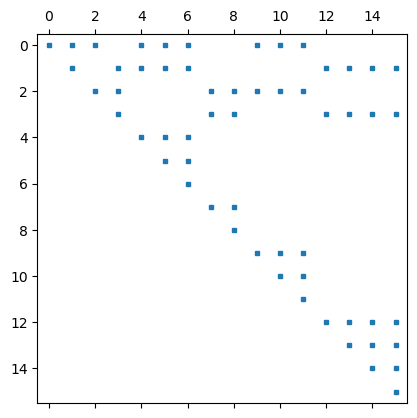

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spy(A_tilde, markersize=3)

In [25]:
from qiskit_optimization.algorithms import CplexOptimizer

In [26]:
cplex_optimizer = CplexOptimizer()
qubo_minimization_result = cplex_optimizer.solve(mod_qubo)

In [27]:
print("minimum point (binary): b_min = ", qubo_minimization_result.x)
print("minimum value: f_3(b_min) = ", qubo_minimization_result.fval)

minimum point (binary): b_min =  [0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]
minimum value: f_3(b_min) =  -9.0


In [28]:
b_min = qubo_minimization_result.x
p_min = conv.interpret(b_min)
print("minimum point (integer): p_min = ", p_min)

minimum point (integer): p_min =  [0. 1. 0. 1.]


In [68]:
print(mod.prettyprint())

Problem name: ET

Maximize
  -18*x_0_2 + 5*x_0_3 - 112*x_1_2 + 4*x_1_3

Subject to
  Linear constraints (4)
    4*x_0_2 + 4*x_0_3 <= 4  'cons_constraint_0'
    3*x_1_2 + 3*x_1_3 <= 3  'cons_constraint_1'
    4*x_0_2 + 3*x_1_2 <= 7  'pros_constraint_2'
    4*x_0_3 + 3*x_1_3 <= 10  'pros_constraint_3'

  Binary variables (4)
    x_0_2 x_0_3 x_1_2 x_1_3



In [69]:
df[df["Hour"]==23]

,Hour,Participant,Type,Price (cents/KWh),Quantity (KW)
1418,23,0,Bid,13,4
1419,23,1,Bid,12,3
1420,23,2,Ask,31,7
1421,23,3,Ask,8,10


## QAOA

In [31]:
from qiskit.circuit.library import QAOAAnsatz

In [32]:
ising, ising_offset = mod_qubo.to_ising()

In [33]:
#qaoa_reps = 2
#qaoa_ansatz = QAOAAnsatz(cost_operator=ising, reps=qaoa_reps, name = "qaoa")
#qaoa_ansatz.measure_active()

In [34]:
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Estimator
 
estimator = Estimator(approximation=True, run_options={"shots": None})
 
op = ising
states_op = QuantumCircuit(len(ising.paulis[0]))
states_op.h(range(len(ising.paulis[0])))
 
expectation_value = estimator.run(states_op, op).result().values + ising_offset
 
print(expectation_value)

[6920.5]


In [35]:
from typing import List

def energy_evaluation(parameter_values: List[float]):
    parameter_bindings = dict(zip(qaoa_ansatz.parameters, parameter_values))
    qaoa_with_parameters = qaoa_ansatz.bind_parameters(parameter_bindings)
    qaoa_with_parameters_decomposed = qaoa_with_parameters.decompose(reps=3)
    estimator = Estimator(approximation=True, run_options={"shots": None})
    expectation_value = estimator.run(qaoa_with_parameters_decomposed, ising).result().values + ising_offset
    return expectation_value[0]

In [36]:
betas = [1.23, 2.31]
gammas = [3.21, 4.32]

parameter_values = [*betas, *gammas]
parameters = qaoa_ansatz.parameters

parameter_bindings = dict(zip(parameters, parameter_values))

qaoa_with_parameters = qaoa_ansatz.bind_parameters(parameter_bindings)

energy_evaluation([*betas, *gammas])

7498.412707115933

In [37]:
random_generator = np.random.default_rng(1234)

In [46]:
from qiskit.algorithms.optimizers import COBYLA

betas_initial_guess = np.pi*random_generator.random(qaoa_reps)
gammas_initial_guess = 2*np.pi*random_generator.random(qaoa_reps)
parameter_values_initial_guess = [*betas_initial_guess, *gammas_initial_guess]
cobyla_optimizer = COBYLA()
result_optimization = cobyla_optimizer.minimize(
fun=energy_evaluation, x0=parameter_values_initial_guess)
parameter_values_optimized = result_optimization.x
energy_optimized = result_optimization.fun
# Number of evalutions of energy_evaluation
number_function_evaluations = result_optimization.nfev
print(f"Optimized parameters: {parameter_values_optimized}")
print(f"Expectation value: {energy_optimized}")
print(f"Number function evaluations: {number_function_evaluations}")

Optimized parameters: [2.89102181 0.53705953 2.35175066 3.65056544]
Expectation value: 5413.483472346023
Number function evaluations: 41


In [47]:
from qiskit_aer import AerSimulator
number_of_shots = 8000
aer_simulator = AerSimulator(method="statevector", shots=number_of_shots)
# Decompose the circuit such that the gates can be simulated with the
# AerSimulator
qaoa_with_parameters_decomposed = qaoa_with_parameters.decompose(reps=3)
result = aer_simulator.run(qaoa_with_parameters_decomposed).result()

In [48]:
parameter_bindings = dict(
zip(qaoa_ansatz.parameters, parameter_values_optimized))
qaoa_with_parameters = qaoa_ansatz.bind_parameters(parameter_bindings)
qaoa_with_parameters_decomposed = qaoa_with_parameters.decompose(reps=3)
result = aer_simulator.run(qaoa_with_parameters_decomposed).result()
counts = result.get_counts()

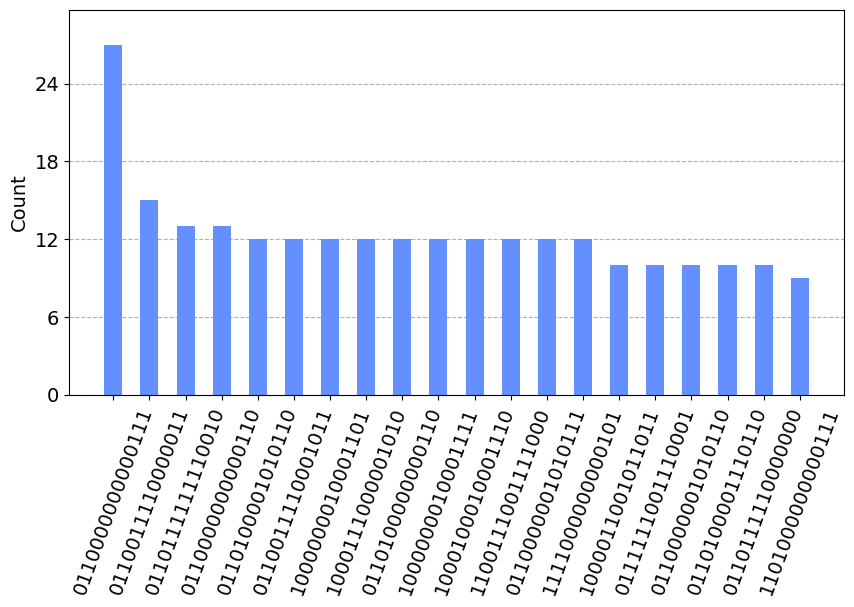

In [50]:
from qiskit.visualization import plot_histogram
counts = result.get_counts()
# Plot the 40 bitstrings with the highest count.
plot_histogram(
counts,
number_to_keep=20,
sort="value_desc",
bar_labels=False,
figsize=(10,5))

### QAOA clear

In [70]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Estimator
 

In [207]:
from typing import List

ising, ising_offset = mod_qubo.to_ising()

def energy_evaluation(parameter_values: List[float]):
    parameter_bindings = dict(zip(qaoa_ansatz.parameters, parameter_values))
    qaoa_with_parameters = qaoa_ansatz.bind_parameters(parameter_bindings)
    qaoa_with_parameters_decomposed = qaoa_with_parameters.decompose(reps=15)
    estimator = Estimator(approximation=True, run_options={"shots": None})
    expectation_value = estimator.run(qaoa_with_parameters_decomposed, ising).result().values + ising_offset
    return expectation_value[0]

betas = [101.23, 104.31]
gammas = [103.21, 204.32]

parameter_values = [*betas, *gammas]
parameters = qaoa_ansatz.parameters

parameter_bindings = dict(zip(parameters, parameter_values))

qaoa_with_parameters = qaoa_ansatz.bind_parameters(parameter_bindings)

energy_evaluation([*betas, *gammas])

7112.113066640961

In [208]:
random_generator = np.random.default_rng(1234)

In [209]:
from qiskit.algorithms.optimizers import COBYLA

betas_initial_guess = np.pi*random_generator.random(qaoa_reps)
gammas_initial_guess = 2*np.pi*random_generator.random(qaoa_reps)
parameter_values_initial_guess = [*betas_initial_guess, *gammas_initial_guess]
cobyla_optimizer = COBYLA()
result_optimization = cobyla_optimizer.minimize(
fun=energy_evaluation, x0=parameter_values_initial_guess)
parameter_values_optimized = result_optimization.x
energy_optimized = result_optimization.fun
# Number of evalutions of energy_evaluation
number_function_evaluations = result_optimization.nfev
print(f"Optimized parameters: {parameter_values_optimized}")
print(f"Expectation value: {energy_optimized}")
print(f"Number function evaluations: {number_function_evaluations}")

Optimized parameters: [4.06870326 1.19450143 5.80090851 1.64402227]
Expectation value: 5720.106482269705
Number function evaluations: 47


Optimized parameters: [3.97742115 2.70602569 4.46558273 5.14329084]
Expectation value: 5734.752832622897
Number function evaluations: 50


Optimized parameters: [4.06870326 1.19450143 5.80090851 1.64402227]
Expectation value: 5720.106482269705
Number function evaluations: 47


Optimized parameters: [1.02903126 1.25518298 2.50226982 2.96769672]
Expectation value: 4751.712142585914
Number function evaluations: 45

In [210]:
from qiskit_aer import AerSimulator

number_of_shots = 80000
aer_simulator = AerSimulator(method="statevector", shots=number_of_shots)
qaoa_with_parameters_decomposed = qaoa_with_parameters.decompose(reps=15)
result = aer_simulator.run(qaoa_with_parameters_decomposed).result()

parameter_bindings = dict(
zip(qaoa_ansatz.parameters, parameter_values_optimized))
qaoa_with_parameters = qaoa_ansatz.bind_parameters(parameter_bindings)
qaoa_with_parameters_decomposed = qaoa_with_parameters.decompose(reps=15)
result = aer_simulator.run(qaoa_with_parameters_decomposed).result()
counts = result.get_counts()

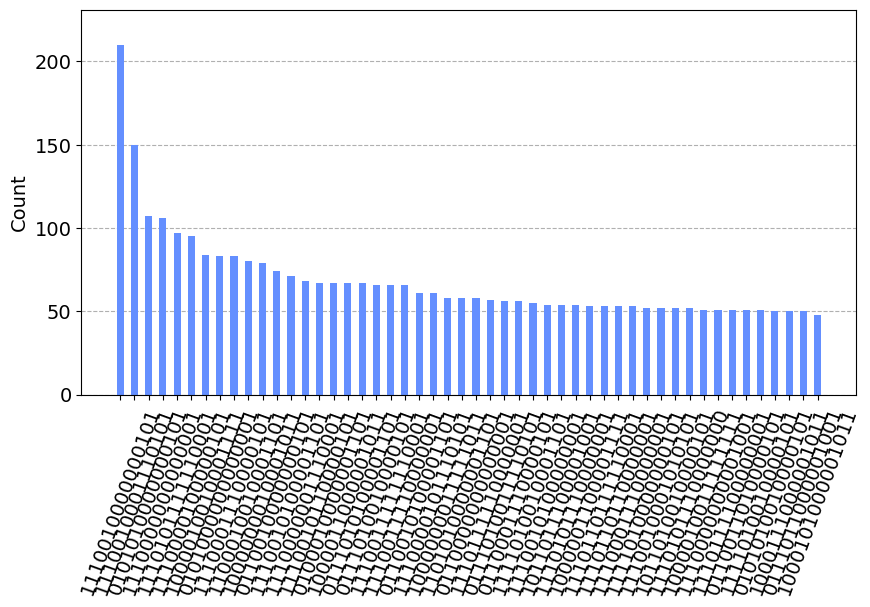

In [211]:
from qiskit.visualization import plot_histogram
counts = result.get_counts()
# Plot the 40 bitstrings with the highest count.
plot_histogram(
counts,
number_to_keep=50,
sort="value_desc",
bar_labels=False,
figsize=(10,5))

In [112]:
print(mod.prettyprint())

Problem name: ET

Maximize
  -18*x_0_2 + 5*x_0_3 - 112*x_1_2 + 4*x_1_3

Subject to
  Linear constraints (4)
    4*x_0_2 + 4*x_0_3 <= 4  'cons_constraint_0'
    3*x_1_2 + 3*x_1_3 <= 3  'cons_constraint_1'
    4*x_0_2 + 3*x_1_2 <= 7  'pros_constraint_2'
    4*x_0_3 + 3*x_1_3 <= 10  'pros_constraint_3'

  Binary variables (4)
    x_0_2 x_0_3 x_1_2 x_1_3



In [144]:
print(mod_qubo.prettyprint())

Problem name: ET

Minimize
  140*cons_constraint_0@int_slack@0^2
  + 560*cons_constraint_0@int_slack@0*cons_constraint_0@int_slack@1
  + 280*cons_constraint_0@int_slack@0*cons_constraint_0@int_slack@2
  + 560*cons_constraint_0@int_slack@1^2
  + 560*cons_constraint_0@int_slack@1*cons_constraint_0@int_slack@2
  + 140*cons_constraint_0@int_slack@2^2 + 140*cons_constraint_1@int_slack@0^2
  + 560*cons_constraint_1@int_slack@0*cons_constraint_1@int_slack@1
  + 560*cons_constraint_1@int_slack@1^2 + 140*pros_constraint_2@int_slack@0^2
  + 560*pros_constraint_2@int_slack@0*pros_constraint_2@int_slack@1
  + 1120*pros_constraint_2@int_slack@0*pros_constraint_2@int_slack@2
  + 560*pros_constraint_2@int_slack@1^2
  + 2240*pros_constraint_2@int_slack@1*pros_constraint_2@int_slack@2
  + 2240*pros_constraint_2@int_slack@2^2 + 140*pros_constraint_3@int_slack@0^2
  + 560*pros_constraint_3@int_slack@0*pros_constraint_3@int_slack@1
  + 1120*pros_constraint_3@int_slack@0*pros_constraint_3@int_slack@2
  + 8

In [162]:
ising_offset

6920.5